<a href="https://colab.research.google.com/github/vivek-a81/EVA6/blob/main/Session6/Sess6_finalCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp "/content/drive/MyDrive/EVA6/Session 6/model.py" .
# drive.flush_and_unmount()

In [ ]:
import model
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from tqdm import tqdm
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# For training set
train = datasets.MNIST('../data', train=True, download=True, #create directory and give the path, True for training set, download if dataset is not available in local storage
                    transform=transforms.Compose([
                        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                        transforms.ToTensor(), # Convert image to tensor
                        transforms.Normalize((0.1307,), (0.3081,)),# Normalize image with mean and standard deviation
                        transforms.RandomRotation((-5.0, 5.0), fill=(0.1307,)),
                        ])
                    )


# For testing set
test = datasets.MNIST('../data', train=False,  # create the directory for testing dataset, train is false for testing 
                   transform=transforms.Compose([ 
                        transforms.ToTensor(), # Convert image to tensor
                        transforms.Normalize((0.1307,), (0.3081,)) # Normalize the data
                        ])
                   )

In [ ]:
SEED = 1
BATCH_SIZE=64

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available: True


In [ ]:
figure = plt.figure(figsize=(8,6))
dataiter = iter(train_loader)
images, labels = dataiter.next()
num_of_images = 30
for index in range(1, num_of_images + 1):
    plt.subplot(8, 12, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_gn = model.Net(norm='gn').to(device)
summary(model_gn, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
         GroupNorm-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
         GroupNorm-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
        GroupNorm-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]             864
        GroupNorm-14           [-1

In [ ]:
summary(model.Net(norm='ln').to(device), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
         GroupNorm-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
         GroupNorm-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
        GroupNorm-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]             864
        GroupNorm-14           [-1, 12,

In [ ]:
summary(model.Net(norm='bn').to(device), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]             864
      BatchNorm2d-14           [-1, 12,

In [ ]:
def train(model, device, train_loader, optimizer, l1, scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  num_loops = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch 
    # accumulates the gradients on subsequent backward passes. Because of this, when you start your training loop, 
    # ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1 = 0
    lambda_l1 = 0.01
    if l1:
      for p in model.parameter():
        l1 = l1 + p.abs().sum()
    
    loss = loss + lambda_l1*l1

    # Backpropagation
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    # Update LR
    scheduler.step()
    
    # Update pbar-tqdm    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    num_loops += 1
    pbar.set_description(desc= f'Batch_id={batch_idx} Loss={train_loss/num_loops:.5f} Accuracy={100*correct/processed:0.2f}')
  
  return 100*correct/processed, train_loss/num_loops


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    return 100. * correct / len(test_loader.dataset), test_loss

In [ ]:
def save_model(model, epoch, optimizer, name_exp):
  state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()}
  torch.save(state, name_exp+'.pt')

In [ ]:
def fit(norm, NUM_EPOCHS=20, l1=False, l2=False, drop= 0.025, num_groups=4, exp_name='experiment'):
  training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()
  best_accuracy = 0
  net =  model.Net(norm=norm, drop=drop, num_groups=num_groups).to(device)
  if l2:
    optimizer = optim.SGD(net.parameters(), lr=0.017, momentum=0.9, weight_decay=1e-4)
  else:
    optimizer = optim.SGD(net.parameters(), lr=0.017, momentum=0.9)
  scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.017, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

  for epoch in range(1,NUM_EPOCHS+1):
      print("EPOCH:", epoch)
      train_acc, train_loss = train(net, device, train_loader, optimizer, l1, scheduler)
      test_acc, test_loss = test(net, device, test_loader)

      if(test_acc > best_accuracy):
        best_accuracy = test_acc
        #Save this model
        save_model(net, epoch, optimizer, exp_name)

      training_acc.append(train_acc)
      training_loss.append(train_loss)
      testing_acc.append(test_acc)
      testing_loss.append(test_loss)
      
  return net, (training_acc, training_loss, testing_acc, testing_loss)

# Model Version 1: 
Network with Group Normalization + L1

In [ ]:
exp_name = 'model_GN+L1'
model_gn, history_gn = fit(norm='gn', NUM_EPOCHS=25, l1=True, exp_name=exp_name)

#Load the best model for further evalution
model_gn = model.Net(norm='gn').to(device)
model_gn.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_gn[3][ep-1], "Accuracy= ",  history_gn[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2774, Accuracy: 9316/10000 (93.16%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0935, Accuracy: 9744/10000 (97.44%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9815/10000 (98.15%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0682, Accuracy: 9805/10000 (98.05%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0810, Accuracy: 9759/10000 (97.59%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9869/10000 (98.69%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9841/10000 (98.41%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9889/10000 (98.89%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9893/10000 (98.93%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9904/10000 (99.04%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9904/10000 (99.04%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9913/10000 (99.13%)

EPOCH: 15


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9906/10000 (99.06%)

EPOCH: 16


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9918/10000 (99.18%)

EPOCH: 17


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9920/10000 (99.20%)

EPOCH: 18


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9923/10000 (99.23%)

EPOCH: 19


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9933/10000 (99.33%)

EPOCH: 21


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 23


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9941/10000 (99.41%)

EPOCH: 24


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9946/10000 (99.46%)

EPOCH: 25


Batch_id=937 Loss=0.01879 Accuracy=99.44: 100%|██████████| 938/938 [00:13<00:00, 71.13it/s]



Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

Best Model loss= 0.018498428060673176 Accuracy=  99.46


# Model Version 2: 
Network with Layer Normalization + L2

In [ ]:
exp_name = 'model_LN+L2'
model_ln, history_ln = fit(norm='ln', NUM_EPOCHS=25, l2=True, exp_name=exp_name)

#Load the best model for further evalution
model_ln = model.Net(norm='ln').to(device)
model_ln.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_ln[3][ep-1], "Accuracy= ",  history_ln[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1774, Accuracy: 9625/10000 (96.25%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9834/10000 (98.34%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9856/10000 (98.56%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9793/10000 (97.93%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0686, Accuracy: 9788/10000 (97.88%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9859/10000 (98.59%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9876/10000 (98.76%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9867/10000 (98.67%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9906/10000 (99.06%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9911/10000 (99.11%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9923/10000 (99.23%)

EPOCH: 18


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9917/10000 (99.17%)

EPOCH: 20


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 22


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9948/10000 (99.48%)

EPOCH: 23


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9949/10000 (99.49%)

EPOCH: 24


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9955/10000 (99.55%)

EPOCH: 25


Batch_id=937 Loss=0.01809 Accuracy=99.46: 100%|██████████| 938/938 [00:13<00:00, 71.13it/s]



Test set: Average loss: 0.0158, Accuracy: 9954/10000 (99.54%)

Best Model loss= 0.015431761919055135 Accuracy=  99.55


# Model Version 3: 
Network with L1 + L2 + BN

In [ ]:
exp_name = 'model_BN+L1+L2'
model_bn, history_bn = fit(norm='bn', NUM_EPOCHS=25, l1=True, l2=True, exp_name=exp_name)

#Load the best model for further evalution
model_bn = model.Net(norm='bn').to(device)
model_bn.load_state_dict(torch.load(exp_name+'.pt')['state_dict'])
ep = torch.load(exp_name+'.pt')['epoch']
print('Best Model loss=', history_bn[3][ep-1], "Accuracy= ",  history_bn[2][ep-1])

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1509, Accuracy: 9705/10000 (97.05%)

EPOCH: 2


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0771, Accuracy: 9775/10000 (97.75%)

EPOCH: 3


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9847/10000 (98.47%)

EPOCH: 4


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9853/10000 (98.53%)

EPOCH: 5


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9880/10000 (98.80%)

EPOCH: 6


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9860/10000 (98.60%)

EPOCH: 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9890/10000 (98.90%)

EPOCH: 8


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9913/10000 (99.13%)

EPOCH: 13


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9920/10000 (99.20%)

EPOCH: 16


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9924/10000 (99.24%)

EPOCH: 17


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

EPOCH: 20


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

EPOCH: 21


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9948/10000 (99.48%)

EPOCH: 23


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9943/10000 (99.43%)

EPOCH: 24


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 25


Batch_id=937 Loss=0.01893 Accuracy=99.43: 100%|██████████| 938/938 [00:13<00:00, 71.52it/s]



Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

Best Model loss= 0.018745553446467965 Accuracy=  99.48


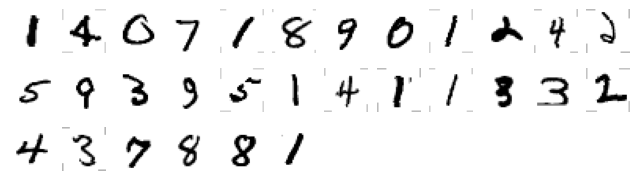

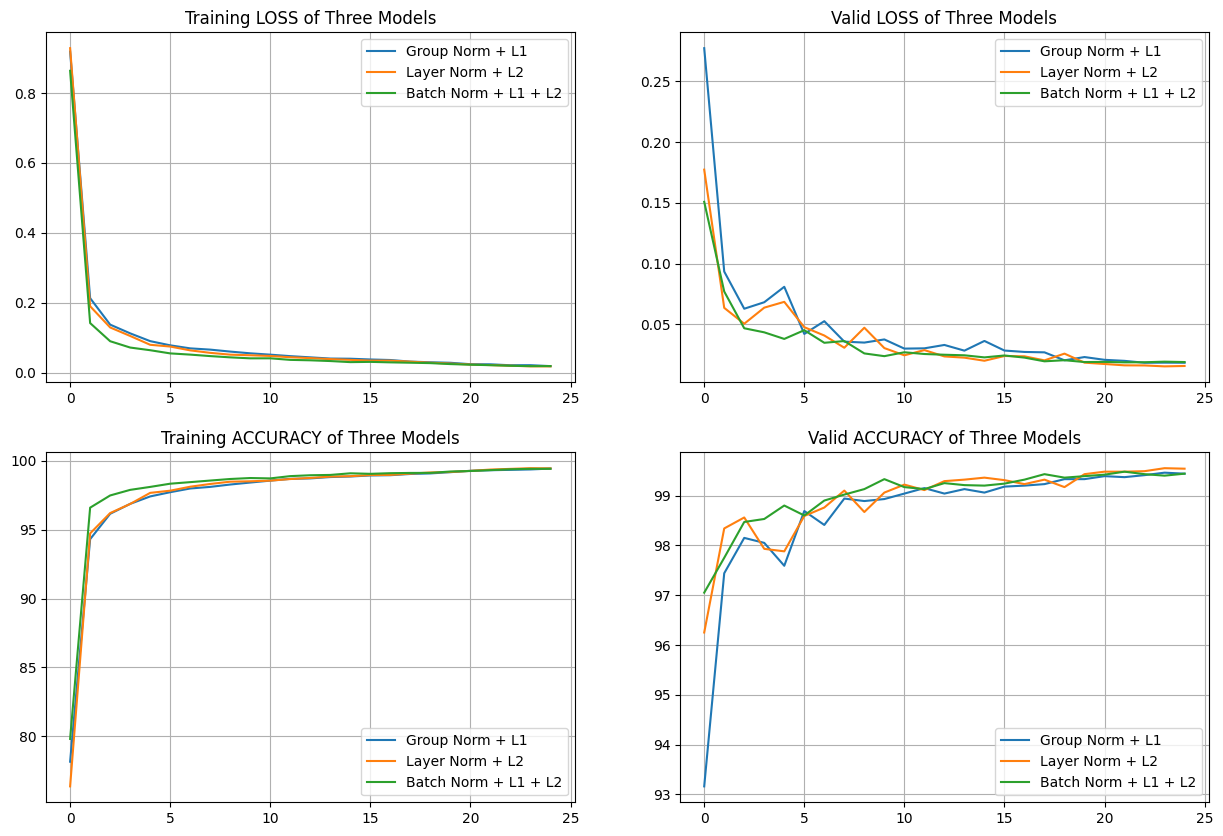

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0,0].set_title('Training LOSS of Three Models')
axs[0,0].plot(history_gn[1], label='Group Norm + L1')
axs[0,0].plot(history_ln[1], label='Layer Norm + L2')
axs[0,0].plot(history_bn[1], label='Batch Norm + L1 + L2')
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].set_title('Valid LOSS of Three Models')
axs[0,1].plot(history_gn[3], label='Group Norm + L1')
axs[0,1].plot(history_ln[3], label='Layer Norm + L2')
axs[0,1].plot(history_bn[3], label='Batch Norm + L1 + L2')
axs[0,1].legend()
axs[0,1].grid()

axs[1,0].set_title('Training ACCURACY of Three Models')
axs[1,0].plot(history_gn[0], label='Group Norm + L1')
axs[1,0].plot(history_ln[0], label='Layer Norm + L2')
axs[1,0].plot(history_bn[0], label='Batch Norm + L1 + L2')
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].set_title('Valid ACCURACY of Three Models')
axs[1,1].plot(history_gn[2], label='Group Norm + L1')
axs[1,1].plot(history_ln[2], label='Layer Norm + L2')
axs[1,1].plot(history_bn[2], label='Batch Norm + L1 + L2')
axs[1,1].legend()
axs[1,1].grid()
plt.show()

In [ ]:
def plot_misclassified(model, test_loader, norm_name):
  count = 0
  k = 0
  misclf = list()
  while count<=20:
    img, label = test_loader.dataset[k]
    pred = model(img.unsqueeze(0).to(device)) # Prediction
    pred = pred.argmax().item()

    k += 1
    if pred!=label:
      misclf.append((img, label, pred))
      count += 1
  
  rows, cols = 5,4
  figure = plt.figure(figsize=(10,14))

  for i in range(1, cols * rows + 1):
    img, label, pred = misclf[i-1]

    figure.add_subplot(rows, cols, i) # adding sub plot
    plt.suptitle(norm_name, fontsize=10)
    plt.title(f"Predcited label {pred}\n True Label: {label}") # title of plot
    plt.axis("off") # hiding the axis
    plt.imshow(img.squeeze(), cmap="gray") # showing the plot

  plt.show()

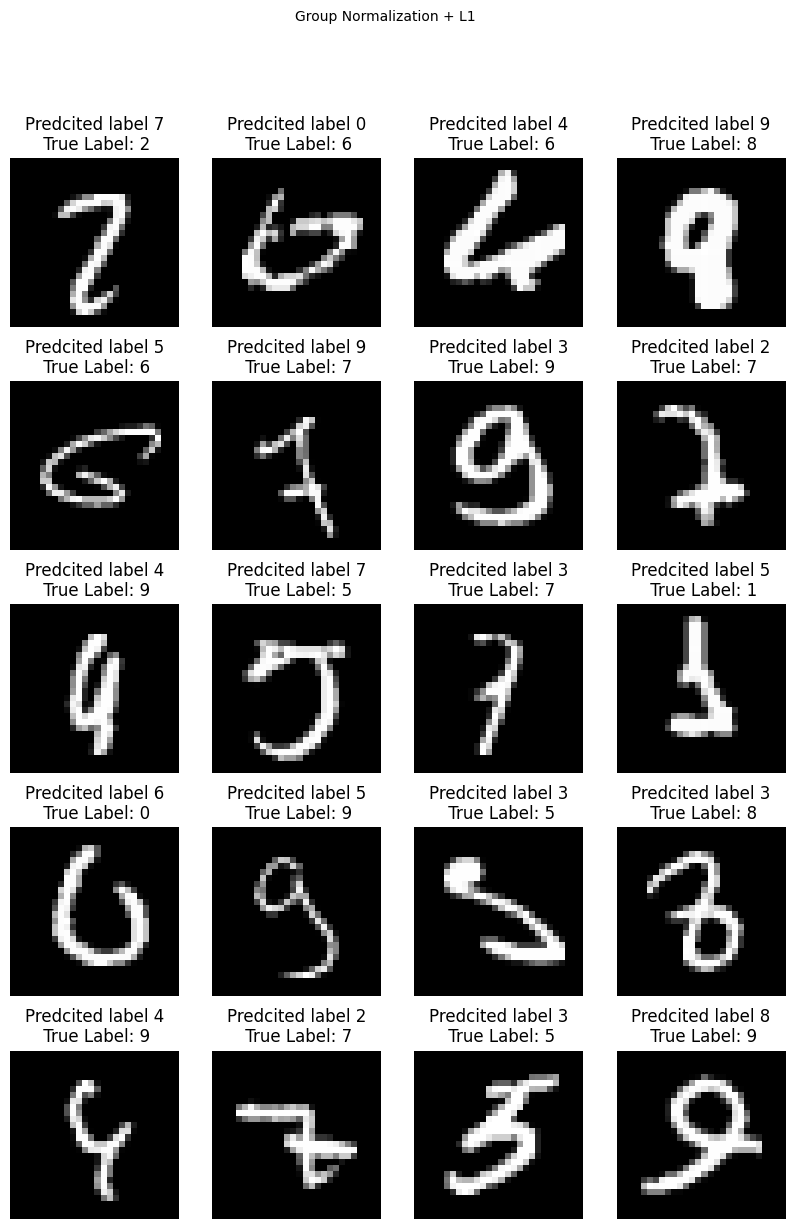

In [ ]:
plot_misclassified(model_gn, test_loader, 'Group Normalization + L1')

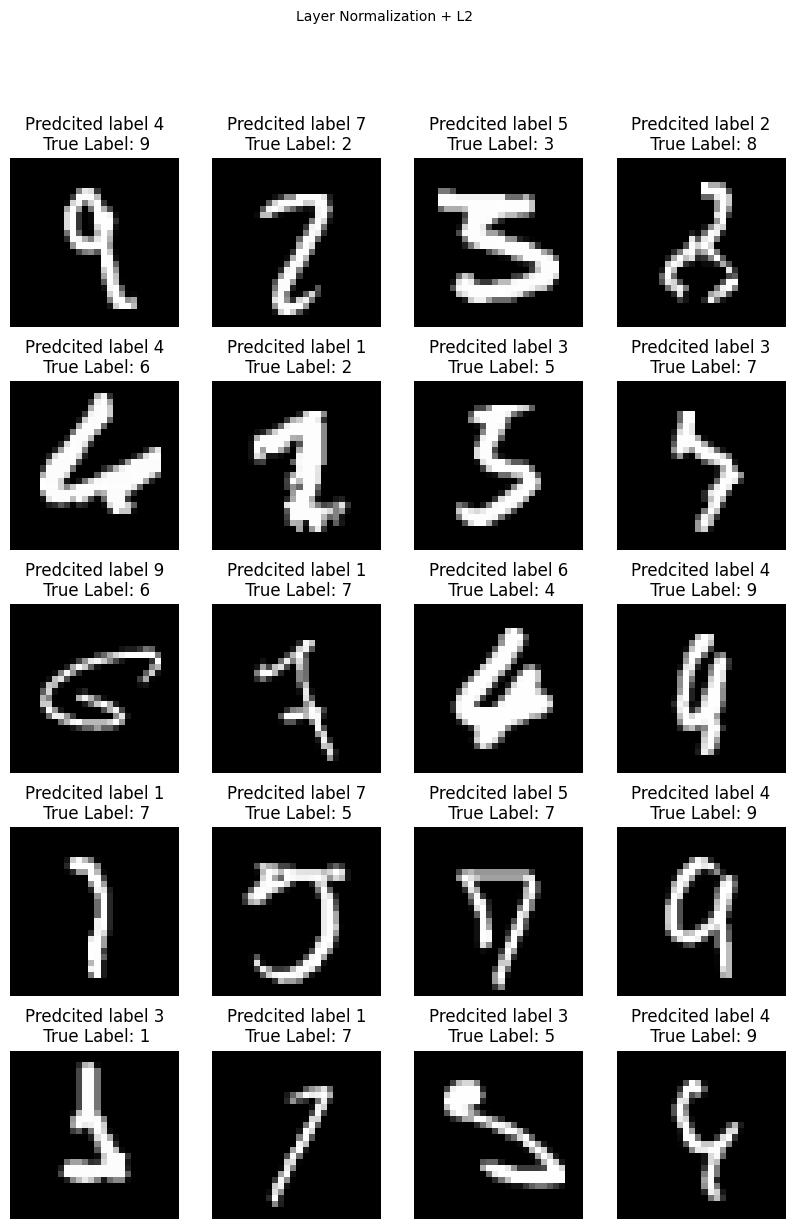

In [ ]:
plot_misclassified(model_ln, test_loader, 'Layer Normalization + L2')

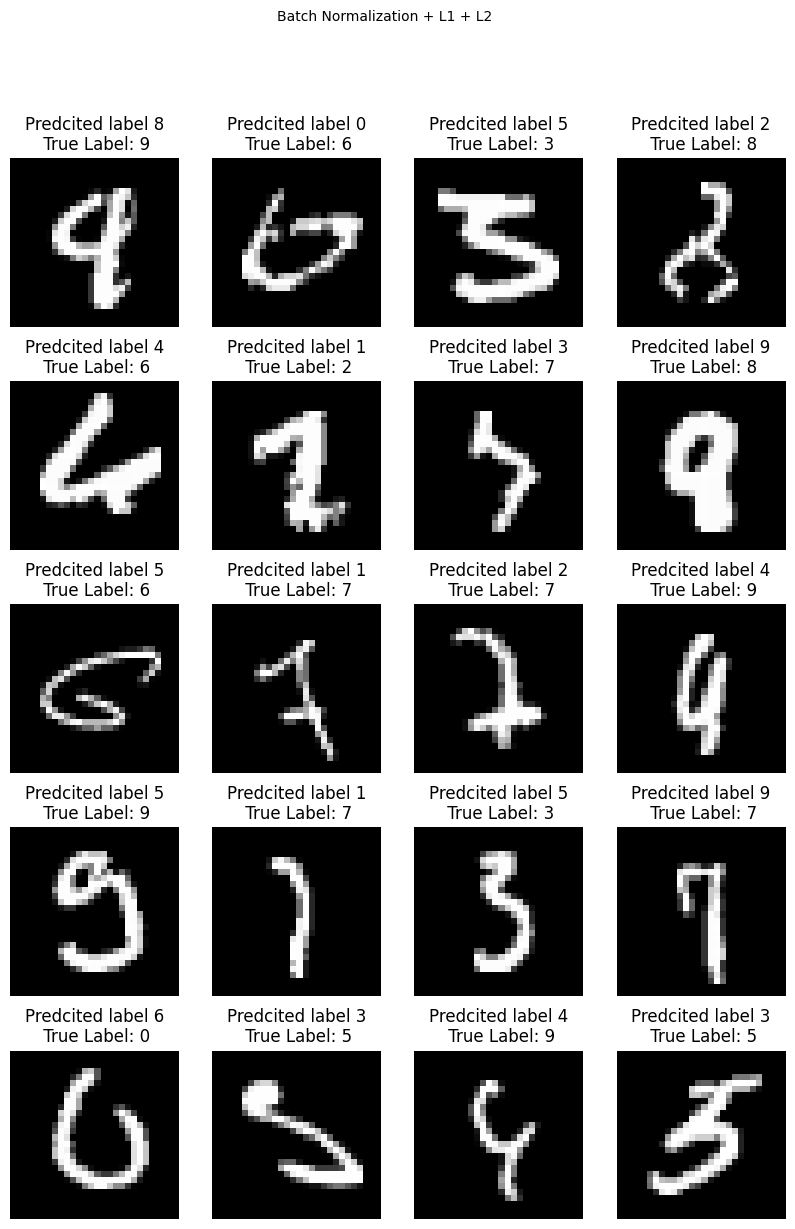

In [ ]:
plot_misclassified(model_bn, test_loader, 'Batch Normalization + L1 + L2')

In [ ]:
def error_rate(model, test_loader):
  model.eval()
  err_count = 0

  for img, target in test_loader:
    img, target = img.to(device), target.to(device)
    output = model(img)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    err_count += pred.not_equal(target.view_as(pred)).sum().item()
  
  return (100. * err_count / len(test_loader.dataset))

In [ ]:
print('Group Norm + L1 \t |\t', error_rate(model_gn, test_loader))
print('Layer Norm + L2 \t |\t', error_rate(model_ln, test_loader))
print('Batch Norm + L1 + L2\t |\t', error_rate(model_bn, test_loader))

Group Norm + L1 	 |	 0.54
Layer Norm + L2 	 |	 0.45
Batch Norm + L1 + L2	 |	 0.62
